In [1]:
from library import *
import json
import os
from nodes import *
from utils import *
from collections import *
import itertools
import pandas as pd
import openpyxl
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
def get_combination_pairs(arr):
    n = len(arr)
    combinations = []
    result = []
    for size in range(1, n + 1):
        for i in range(n - size + 1):
            combinations.append(arr[i:i+size])
    for i in range(len(combinations)):
        for j in range(n):
            if i != j:
                result.append([combinations[i], [arr[j]]])
    return result

In [5]:
path_to_json = '/Users/nghiahoang/Documents/nghiahoang/Summer Research/metagraph/attack-flows'
json_files = [pos_json for pos_json in os.listdir(
    path_to_json) if pos_json.endswith('.json')]
ignore_files = ["JP Morgan Breach.json",
                "FIN13 Case 2.json", "Gootloader.json", "Target Breach.json", "Hancitor DLL.json", "NotPetya.json", "Ragnar Locker.json"]
big_files = ["FIN13 Case 1.json", "Cobalt Kitty Campaign.json", "apt-chaining-vulnerabilities.json", "SolarWinds.json", "Conti Ransomware.json", "WhisperGate.json", "IcedID.json", "cleared-defense-contractor-networks.json"]
# # DEFINE NODE CLASS
i = 0
excel_path = 'mainMetagraph.xlsx'
x = []
y = []
print(len(json_files))
print(len(ignore_files))
print(len(big_files))
print(len(json_files)-len(ignore_files)-len(big_files))

40
7
8
25


In [6]:
for i in range(len(json_files)):
    file = json_files[i]
    if file in ignore_files or file in big_files or len(file) > 30:
        print('Error: ', file)
        continue
    if file in big_files or len(file) > 30:
        print('Big file: ', file)
        continue
    print(file)
    f = open('attack-flows/'+file)
    data = json.load(f)
    objects = data["objects"]

    # Create nodes from json file

    nodeById, allNodes = convertAllToNodes(objects)

    # Create list for metagraph and add "attack-action", "attack-asset" and "STIX Common Properties" node to the list
    generating_set = set()

    for node in allNodes["actions"]:
        generating_set.add(node)
    # Create metagraph
    mg = Metagraph(generating_set)

    elementsSum = 0
    for k, v in allNodes.items():
        if k != 'operators':
            elementsSum += len(v)

    flow_dict = defaultdict(list)
    
    # set outNodes for each operator
    for node in allNodes["operators"]:
        outnodes = []
        for ref in node.effect_refs:
            for outNode in generating_set:
                if outNode.getId() == ref:
                    outnodes.append(outNode)
            node.setOutNodes(outnodes)

    # Generate edges for the metagraph
    mg, flow_dict = createAttackEdge(mg, generating_set, nodeById, flow_dict)

    mg, flow_dict = createOperatorEdge(mg, allNodes["operators"], flow_dict)

    for node in allNodes["operators"]:
        print(node.inNodes)

    # from relationships
    mg, flow_dict = createRelationshipEdge(
        mg, allNodes["relationships"], nodeById, flow_dict)

    # metagraph adjacency matrix and incidence
    A = mg.adjacency_matrix()
    I = mg.incidence_matrix()

    combination_pairs = get_combination_pairs(list(generating_set))

    number_of_metapaths = 0
    avg_edge_list = 0
    avg_include_nodes = 0
    metapaths_set = set()
    longest_metapath = float('-inf')
    shortest_metapath = float('inf')
    freq_nodes = {}
    for pair in combination_pairs:
        if set(pair[0]) != set(pair[1]):
            metapaths = mg.get_all_metapaths_from(set(pair[0]), set(pair[1]))
            if metapaths != None and len(metapaths) > 0:
                metapaths_set.update(metapaths)
                for metapath in metapaths:
                    number_of_metapaths += 1
                    longest_metapath = max(longest_metapath, len(metapath.edge_list))
                    shortest_metapath = min(shortest_metapath, len(metapath.edge_list))
                    included_nodes = set()
                    avg_edge_list += len(metapath.edge_list)
                    for edge in metapath.edge_list:
                        for tmp_node in edge.invertex.union(edge.outvertex):
                            if tmp_node not in freq_nodes:
                                freq_nodes[tmp_node] = 1
                            else:
                                freq_nodes[tmp_node]+=1
                            included_nodes.add(tmp_node)
                    avg_include_nodes += len(included_nodes)
    sorted_tuples = sorted(freq_nodes.items(), key=lambda x: x[1], reverse=True)
    number_of_metapaths = len(metapaths_set)
    avg_include_nodes = avg_include_nodes//number_of_metapaths
    avg_edge_list = avg_edge_list//number_of_metapaths
    x.append(len(mg.edges))
    y.append(sorted_tuples[0][1])
    # print('number of nodes:', len(generating_set))
    # print('number of edges:', len(mg.edges))
    # print('Number of metapaths:', number_of_metapaths)
    # print('Average number of include nodes:', avg_include_nodes)
    # print('Average path length:', avg_edge_list)
    # print('Highest degree nodes:', mg.get_most_degree_nodes())
    # print('Highest rank nodes:', mg.get_most_rank_nodes())
    # print(f'Attackflow {file[:-5]} has {len(generating_set)} nodes, {len(mg.edges)} edges, {number_of_metapaths} metapaths (longest: {longest_metapath}, shortest: {shortest_metapath}), the average paths length is {avg_edge_list}, the nodes with highest degree is {mg.get_most_degree_nodes()}, the nodes with highest rank is {mg.get_most_rank_nodes()}.')


Muddy Water.json
[]
Error:  Target Breach.json
SWIFT Heist.json
[Send money to individual accounts, Send money to Philippines account] [T1070.004]
[]
[Send money to individual accounts, Send money to Philippines account]
Tesla.json
solarwinds 2.json
Error:  apt-chaining-vulnerabilities.json
Error:  network-infrastructure-devicesent.json
Error:  JP Morgan Breach.json
apt-compromise.json
[T1110.003, T1110.001, T1078] [T1569.002]
[T1195.002, T1195.001:] [T1584]
[T1083, T1518.001, T1057, T1518] [T1027, T1027.003, T1070.004]
[T1110.003, T1110.001, T1078]
[T1195.002, T1195.001:]
[T1083, T1518.001, T1057, T1518]
Sony Malware.json
[Dismounts, T1485, T1489] [T1132]
[Dismounts, T1485, T1489]
Equifax Breach.json
[T1589.001, T1590] [T1573]
[T1140, T1560] [T1048.002]
[T1589.001, T1590]
[T1140, T1560]
Conti CISA Alert.json
[]
[]
[]


KeyboardInterrupt: 

In [5]:
for i in range(len(json_files)):
    file = json_files[i]
    if file in ignore_files or file in big_files or len(file) > 30:
        print('Error: ', file)
        continue
    if file in big_files or len(file) > 30:
        print('Big file: ', file)
        continue
    print(file)
    f = open('attack-flows/'+file)
    data = json.load(f)
    objects = data["objects"]

    # Create nodes from json file

    nodeById, allNodes = convertAllToNodes(objects)

    # Create list for metagraph and add "attack-action", "attack-asset" and "STIX Common Properties" node to the list
    generating_set = set()

    for node in allNodes["actions"]:
        generating_set.add(node)
    # Create metagraph
    mg = Metagraph(generating_set)

    elementsSum = 0
    for k, v in allNodes.items():
        if k != 'operators':
            elementsSum += len(v)

    flow_dict = defaultdict(list)
    
    # set outNodes for each operator
    for node in allNodes["operators"]:
        outnodes = []
        for ref in node.effect_refs:
            for outNode in generating_set:
                if outNode.getId() == ref:
                    outnodes.append(outNode)
            node.setOutNodes(outnodes)

    # Generate edges for the metagraph
    mg, flow_dict = createAttackEdge(mg, generating_set, nodeById, flow_dict)

    mg, flow_dict = createOperatorEdge(mg, allNodes["operators"], flow_dict)
    for node in allNodes["operators"]:
        print('length inNodes:',len(node.inNodes))

    # from relationships
    mg, flow_dict = createRelationshipEdge(
        mg, allNodes["relationships"], nodeById, flow_dict)

    # metagraph adjacency matrix and incidence
    A = mg.adjacency_matrix()
    I = mg.incidence_matrix()

    combination_pairs = get_combination_pairs(list(generating_set))

    number_of_metapaths = 0
    avg_edge_list = 0
    avg_include_nodes = 0
    metapaths_set = set()
    longest_metapath = float('-inf')
    shortest_metapath = float('inf')
    startNodes = mg.getStartNodes()
    endNodes = mg.getEndNodes()
    metapaths = mg.get_all_metapaths_from(set(startNodes), set(endNodes))
    # if metapaths != None:
    #     print(f'Number of metapath from {startNodes} to {endNodes} are {len(metapaths)}')
    # for pair in combination_pairs:
    #     if set(pair[0]) != set(pair[1]):
    #         metapaths = mg.get_all_metapaths_from(set(pair[0]), set(pair[1]))
    #         if metapaths != None and len(metapaths) > 0:
    #             metapaths_set.update(metapaths)
    #             for metapath in metapaths:
    #                 number_of_metapaths += 1
    #                 longest_metapath = max(longest_metapath, len(metapath.edge_list))
    #                 shortest_metapath = min(shortest_metapath, len(metapath.edge_list))
    #                 included_nodes = set()
    #                 avg_edge_list += len(metapath.edge_list)
    #                 for edge in metapath.edge_list:
    #                     for tmp_node in edge.invertex.union(edge.outvertex, pair[0], pair[1]):
    #                         included_nodes.add(tmp_node)
    #                 avg_include_nodes += len(included_nodes)
    # number_of_metapaths = len(metapaths_set)
    # avg_include_nodes = avg_include_nodes//number_of_metapaths
    # avg_edge_list = avg_edge_list//number_of_metapaths

Error:  Muddy Water.json
Error:  Target Breach.json
SWIFT Heist.json
[Send money to individual accounts, Send money to Philippines account] [T1070.004]
length inNodes: 0
length inNodes: 2
Tesla.json
solarwinds 2.json
Error:  apt-chaining-vulnerabilities.json
Error:  network-infrastructure-devicesent.json
Error:  JP Morgan Breach.json
apt-compromise.json
[T1110.001, T1078, T1110.003] [T1569.002]
[T1195.001:, T1195.002] [T1584]
[T1518, T1057, T1518.001, T1083] [T1027, T1027.003, T1070.004]
length inNodes: 3
length inNodes: 2
length inNodes: 4
Sony Malware.json
[T1489, T1485, Dismounts] [T1132]
length inNodes: 3
Equifax Breach.json
[T1590, T1589.001] [T1573]
[T1560, T1140] [T1048.002]
length inNodes: 2
length inNodes: 2
Conti CISA Alert.json
length inNodes: 0
length inNodes: 0
length inNodes: 0
Error:  FIN13 Case 1.json
Error:  Hancitor DLL.json
Uber Breach.json
Error:  Gootloader.json
CISA Iranian APT.json
Error:  SolarWinds.json
Marriott Breach.json
[T1555, Remote Access Trojan] [T1590.

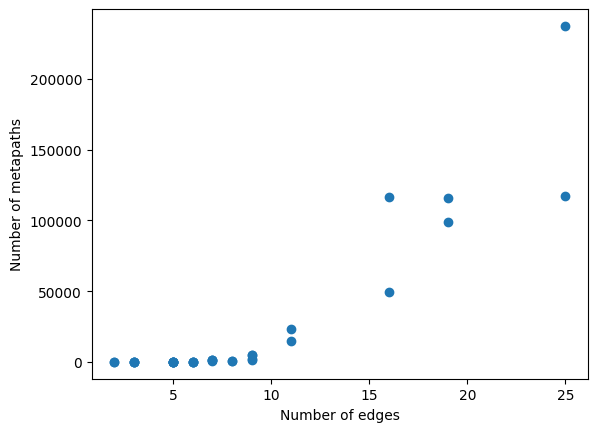

In [9]:
plt.scatter(x,y)

plt.xlabel("Number of edges")
plt.ylabel("Number of metapaths")

plt.show()